In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
!nvidia-smi

Fri Mar 17 07:20:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P3    27W / 124W |    280MiB /  8192MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [5]:
!dir pubmed-rct

 Volume in drive C is OS
 Volume Serial Number is 4E64-E860

 Directory of C:\Users\ahmed\projects-dataScience\Skimlit\pubmed-rct

02/19/2023  08:13 AM    <DIR>          .
03/17/2023  07:17 AM    <DIR>          ..
02/19/2023  08:13 AM    <DIR>          PubMed_200k_RCT
02/19/2023  08:13 AM    <DIR>          PubMed_200k_RCT_numbers_replaced_with_at_sign
02/19/2023  08:13 AM    <DIR>          PubMed_20k_RCT
02/19/2023  08:13 AM    <DIR>          PubMed_20k_RCT_numbers_replaced_with_at_sign
02/19/2023  08:13 AM             2,403 README.md
               1 File(s)          2,403 bytes
               6 Dir(s)  1,766,880,567,296 bytes free


**experimenting with 20k of tha dataset**

In [6]:
dir_path = "pubmed-rct/PubMed_20k_RCT/"
filenames = [dir_path + file for file in os.listdir(dir_path)]
filenames

['pubmed-rct/PubMed_20k_RCT/dev.txt',
 'pubmed-rct/PubMed_20k_RCT/test.txt',
 'pubmed-rct/PubMed_20k_RCT/train.txt']

In [7]:
def get_lines(filename):
    with open(filename,"r") as f:
        return f.readlines()

In [8]:
lines = get_lines(filenames[2])

In [10]:
lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [9]:
def preprocess_text(filename):
    input_lines = get_lines(filename) 
    abstract_lines = "" 
    abstract_samples = [] 
  
 
    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = "" 
        elif line.isspace(): 
            abstract_line_split = abstract_lines.splitlines() 


            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} 
                target_text_split = abstract_line.split("\t") 
                line_data["target"] = target_text_split[0] 
                line_data["text"] = target_text_split[1].lower()  
                line_data["line_number"] = abstract_line_number 
                line_data["total_lines"] = len(abstract_line_split) - 1 
                abstract_samples.append(line_data) 
                
        else: 
              abstract_lines += line
  
    return abstract_samples

In [10]:
train_set = preprocess_text(dir_path+"train.txt")
val_set = preprocess_text(dir_path+"dev.txt")
test_set = preprocess_text(dir_path+"test.txt")

In [11]:
train_set_df =pd.DataFrame(train_set)
val_set_df = pd.DataFrame(val_set)
test_set_df = pd.DataFrame(test_set)

In [13]:
train_set_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of 6 weeks of dail...,0,11
1,METHODS,a total of 125 patients with primary knee oa w...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin 1 ( il-1 ) , il-6 ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( 9...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at 12 w...,9,11


In [14]:
train_set_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

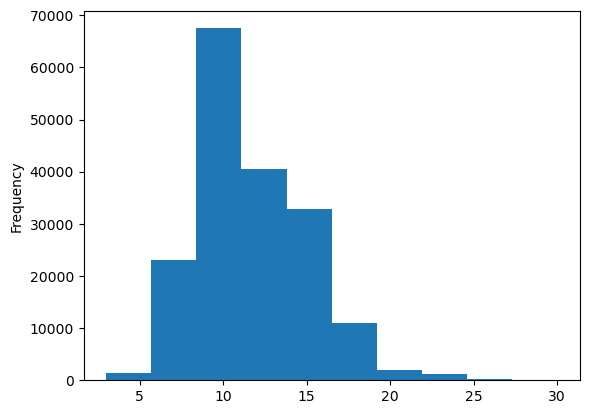

In [15]:
train_set_df.total_lines.plot.hist();

In [16]:
train_sentences = train_set_df["text"].tolist()
val_sentences = val_set_df["text"].tolist()
test_sentences = test_set_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
train_sentences[0]

'to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

In [18]:
from sklearn.preprocessing import OneHotEncoder
Onehot = OneHotEncoder(sparse=False)
train_labels_one_hot = Onehot.fit_transform(train_set_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = Onehot.transform(val_set_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = Onehot.transform(test_set_df["target"].to_numpy().reshape(-1, 1))

In [19]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_set_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_set_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_set_df["target"].to_numpy())

In [21]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [22]:
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Baseline 

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

baseline = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])


In [24]:
baseline.fit(X=train_sentences, 
            y=train_labels_encoded);

In [25]:
baseline.score(val_sentences,
             val_labels_encoded)

0.7317291142592347

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [27]:
baseline_preds = baseline.predict(val_sentences)
baseline_preds

array([0, 1, 3, ..., 4, 4, 1])

In [28]:
calculate_results(val_labels_encoded,baseline_preds)

{'accuracy': 73.17291142592347,
 'precision': 0.7315166696974572,
 'recall': 0.7317291142592347,
 'f1': 0.7058060715307974}

In [29]:
#average length of sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338435903132638

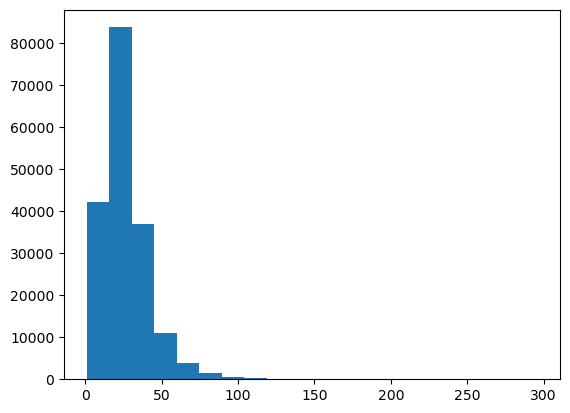

In [41]:
#distribution 
plt.hist(sent_lens, bins=20);

In [42]:
#Numpy's percentile to find the value which covers 95% of the sentence lengths
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [43]:
max(sent_lens)

296

**Section 3.2 of the PubMed 200k RCT paper states the vocabulary size of the PubMed 20k dataset as 68,000. So we'll use that as our max_tokens parameter**

In [47]:
text_vect = TextVectorization(max_tokens=68000, output_sequence_length=55)

In [48]:
text_vect.adapt(train_sentences)

In [55]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vect([target_sentence])}")
print(f"\nshape Vectorized text:\n{text_vect([target_sentence]).shape}")

Text:
toothpaste slurries were prepared by stirring one part by weight of each toothpaste with two parts by weight of deionized water .

Length of text: 22

Vectorized text:
[[ 5580 53822     9  4086    22 53295    90   810    22   184     4   129
   5580     7    53  5997    22   184     4     1  1245     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

shape Vectorized text:
(1, 55)


In [57]:
rct_20k_text_vocab = text_vect.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 68000
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['httpsuploaduminacjpcgiopenbinctrctrcgifunctionbrowsactionbrowstypesummaryrecptnor000008238languagee', 'httpsregisterclinicaltrialsgov', 'httpsmartmicrosurgerycom', 'httpseudractemaeuropaeuindexhtml', 'httpseudractemaeuropaeu']


In [58]:
text_vect.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None}

**create embedding**

In [62]:
token_em = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=256,
                              mask_zero=True,
                              name="token_embedding")

In [64]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vect([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_em(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
toothpaste slurries were prepared by stirring one part by weight of each toothpaste with two parts by weight of deionized water .

Sentence after vectorization (before embedding):
[[ 5580 53822     9  4086    22 53295    90   810    22   184     4   129
   5580     7    53  5997    22   184     4     1  1245     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.01068021 -0.01594638  0.02430845 ...  0.00165189  0.03963946
    0.04808308]
  [ 0.01896686  0.02542423  0.02945052 ... -0.02070307  0.00409804
   -0.01732688]
  [-0.04612988 -0.03863263  0.04277224 ...  0.00307666 -0.03434237
    0.00028412]
  ...
  [-0.03462551  0.02659122  0.04213368 ...  0.04205326  0.01076386
    0.0252579 ]
  [-0.03462551  0.02659122  0.04213368 ...  0.04205326  0.01076386
    0.0252579 ]

**create TensorFlow dataset to fast load**

In [70]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [73]:
for sent , label in train_dataset.take(1):
    print(sent, label)

tf.Tensor(b'to investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .', shape=(), dtype=string) tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float64)


In [74]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [77]:
for sent,label in train_dataset.take(1):
      print(sent.shape, label.shape)

(32,) (32, 5)
